In [1]:
from qiskit import IBMQ
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit import QuantumCircuit, execute, Aer

from qiskit.ignis.verification.topological_codes import RepetitionCode
from qiskit.ignis.verification.topological_codes import lookuptable_decoding
from qiskit.ignis.verification.topological_codes import GraphDecoder
from qiskit.visualization import plot_histogram

from tqdm.auto import tqdm

/tmp/ipykernel_2267907/1145526300.py:9: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.verification.topological_codes import RepetitionCode
/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
p = 0.01
P = 3 * p**2 * (1-p) + p**3 # probability of 2 or 3 errors
print('Probability of a single reply being garbled:',p)
print('Probability of a the majority of three replies being garbled:',P)

Probability of a single reply being garbled: 0.01
Probability of a the majority of three replies being garbled: 0.00029800000000000003


In [3]:
def get_noise(rho_meas,rho_gate):
    error_meas = pauli_error([('X',rho_meas), ('I', 1 - rho_meas)])
    error_gate1 = depolarizing_error(rho_gate, 1)
    error_gate2 = error_gate1.tensor(error_gate1)
    noise_model = NoiseModel()
    # measurement error is applied to measurements
    noise_model.add_all_qubit_quantum_error(error_meas, "measure")
    # single qubit gate error is applied to x gates
    noise_model.add_all_qubit_quantum_error(error_gate1, ["x"])
    # two qubit gate error is applied to cx gates
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"])
    return noise_model

In [4]:
noise_model = get_noise(0.1,0.1)

In [5]:
from qiskit import IBMQ
IBMQ.save_account("69a0c5663de913c06feeb47b6b270ee165045d9a98c00b7baee8b51c260e7dd5837f050c47f21fdcd5b8810a9125020cc70dfa3b37298a4a91790987b40ecfaf")

configrc.store_credentials:WARNING:2024-05-09 08:55:40,143: Credentials already present. Set overwrite=True to overwrite.


In [6]:
device_name = 'simulator_extended_stabilizer'

IBMQ.load_account()
for provider in IBMQ.providers():
    for potential_backend in provider.backends():
        if potential_backend.name()==device_name:
            backend = potential_backend
coupling_map = backend.configuration().coupling_map


In [7]:
line = [i for i in range(25)]

In [8]:
n_min = 3
n_max = int((len(line)+1)/2)
code = {}
for n in range(n_min,n_max+1):
    code[n] = RepetitionCode(n,1)

In [9]:
def get_initial_layout(code,line):
    initial_layout = {}
    for j in range(n):
        initial_layout[code.code_qubit[j]] = line[2*j]
    for j in range(n-1):
        initial_layout[code.link_qubit[j]] = line[2*j+1]
    return initial_layout

In [10]:
circuits = []
for n in tqdm(range(n_min,n_max+1)):
    initial_layout = get_initial_layout(code[n],line)
    for log in ['0','1']:
        circuits.append( transpile(code[n].circuit[log],
                            backend=backend,
                            initial_layout=initial_layout) )

        num_cx = dict(circuits[-1].count_ops())['cx']


100%|██████████| 11/11 [00:08<00:00,  1.25it/s]


In [11]:
job = execute(circuits,Aer.get_backend('qasm_simulator'),
noise_model=noise_model,shots=8192)
raw_results = {}
j = 0
for n in tqdm(range(n_min,n_max+1)):
    raw_results[n] = {}
    for log in ['0','1']:
        raw_results[n][log] = job.result().get_counts(j)
        j += 1

100%|██████████| 11/11 [00:00<00:00, 49.86it/s]


In [12]:
results = {}
for n in tqdm(range(n_min,n_max+1)):
    results[n] = code[n].process_results( raw_results[n] )


100%|██████████| 11/11 [00:00<00:00, 16.11it/s]


In [13]:
dec = {}
for n in tqdm(range(n_min,n_max+1)):
    dec[n] = GraphDecoder(code[n])


100%|██████████| 11/11 [00:00<00:00, 1721.93it/s]


In [14]:
logical_prob_match = {}
for n in tqdm(range(n_min,n_max+1)):
    logical_prob_match[n] = dec[n].get_logical_prob(results[n])

100%|██████████| 11/11 [00:29<00:00,  2.66s/it]


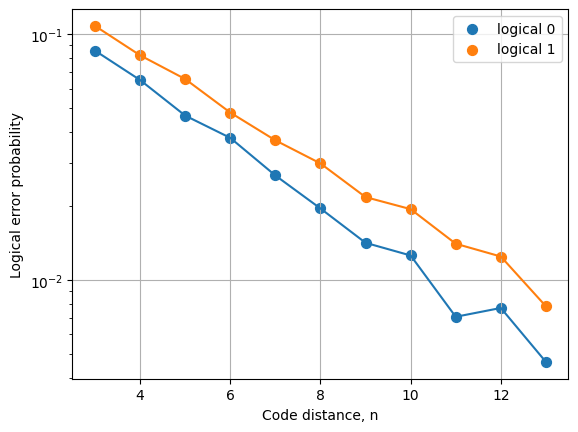

In [15]:
import matplotlib.pyplot as plt
import numpy as np
x_axis = range(n_min,n_max+1)
P = {log: [logical_prob_match[n][log] for n in x_axis] for log in ['0', '1']}
ax = plt.gca()
plt.xlabel('Code distance, n')
plt.ylabel('Logical error probability')
ax.scatter( x_axis, P['0'], label="logical 0", s=50,)
ax.scatter( x_axis, P['1'], label="logical 1", s=50)
plt.plot(x_axis, P['0'])
plt.plot(x_axis, P['1'])
# ax.set_yscale('log')
# ax.set_ylim(ymax=1.5*max(P['0']+P['1']),  
#             ymin=0.75*min([ p for p in P['0']+P['1'] if p>0 ]))
plt.yscale("log")
plt.grid("True")
plt.legend()
# plt.savefig("Mid-noise.pdf")
plt.show()

In [18]:
# noisy simulator bit flip
noise_model = get_noise(0.1,0.1)
qc0 = RepetitionCode(3,1)
# Transpile circuit for noisy basis gates
qc0_tnoise = transpile(qc0, noise_model)


AttributeError: 'NoiseModel' object has no attribute 'properties'

In [ ]:
Noise = [0.1,0.15,0.2,0.25,0.3,0.35,0.4]
P_ = []
for n_ in tqdm(Noise):
    noise_model = get_noise(n_,0.1)
    line = [i for i in range(25)]
    n_min = 3
    n_max = int((len(line)+1)/2)
    code = {}
    for n in range(n_min,n_max+1):
        code[n] = RepetitionCode(n,1)

    def get_initial_layout(code,line):
        initial_layout = {}
        for j in range(n):
            initial_layout[code.code_qubit[j]] = line[2*j]
        for j in range(n-1):
            initial_layout[code.link_qubit[j]] = line[2*j+1]
        return initial_layout


    circuits = []
    for n in tqdm(range(n_min,n_max+1)):
        initial_layout = get_initial_layout(code[n],line)
        for log in ['0','1']:
            circuits.append( transpile(code[n].circuit[log],
                                backend=backend,
                                initial_layout=initial_layout) )

            num_cx = dict(circuits[-1].count_ops())['cx']


    job = execute(circuits,Aer.get_backend('qasm_simulator'),
    noise_model=noise_model,shots=8192)
    raw_results = {}
    j = 0
    for n in tqdm(range(n_min,n_max+1)):
        raw_results[n] = {}
        for log in ['0','1']:
            raw_results[n][log] = job.result().get_counts(j)
            j += 1        

    results = {}
    for n in tqdm(range(n_min,n_max+1)):
        results[n] = code[n].process_results( raw_results[n] )

    dec = {}
    for n in tqdm(range(n_min,n_max+1)):
        dec[n] = GraphDecoder(code[n])

    logical_prob_match = {}
    for n in tqdm(range(n_min,n_max+1)):
        logical_prob_match[n] = dec[n].get_logical_prob(results[n])

    P = {log: [logical_prob_match[n][log] for n in x_axis] for log in ['0', '1']}
    P_.append(P)

100%|██████████| 11/11 [00:09<00:00,  1.19it/s]

100%|██████████| 11/11 [00:00<00:00, 47.32it/s][A

100%|██████████| 11/11 [00:00<00:00, 12.27it/s][A

100%|██████████| 11/11 [00:00<00:00, 1749.15it/s]

100%|██████████| 11/11 [00:09<00:00,  1.22it/s]

100%|██████████| 11/11 [00:00<00:00, 48.04it/s][A

100%|██████████| 11/11 [00:00<00:00, 13.72it/s][A

100%|██████████| 11/11 [00:00<00:00, 1806.40it/s]

100%|██████████| 11/11 [00:11<00:00,  1.05s/it]

100%|██████████| 11/11 [00:00<00:00, 47.54it/s][A

100%|██████████| 11/11 [00:00<00:00, 13.76it/s]

100%|██████████| 11/11 [00:00<00:00, 1801.33it/s]

 55%|█████▍    | 6/11 [00:06<00:07,  1.50s/it]

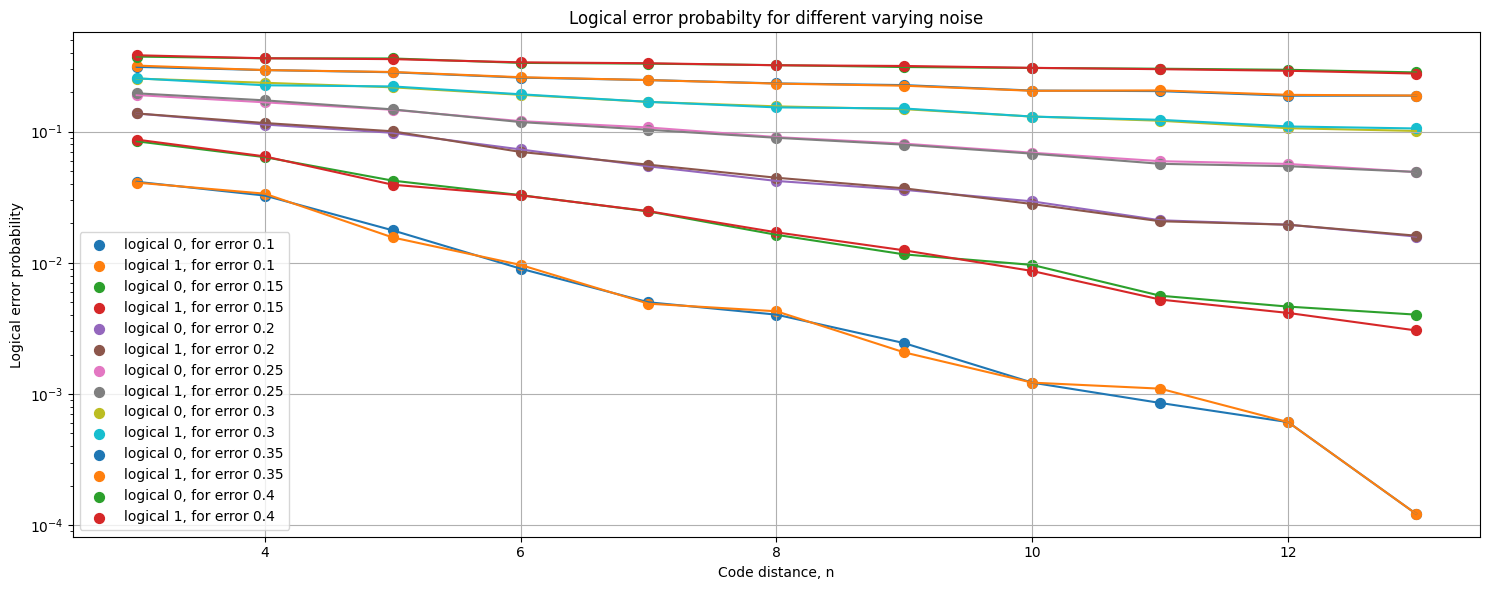

In [110]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(15,6))
for i in range(len(P_)):
    P = P_[i]
    x_axis = range(n_min,n_max+1)
    # P = {log: [logical_prob_match[n][log] for n in x_axis] for log in ['0', '1']}
    ax = plt.gca()
    plt.xlabel('Code distance, n')
    plt.ylabel('Logical error probability')
    ax.scatter(x_axis, P['0'], label=f"logical 0, for error {Noise[i]}", s=50,)
    ax.scatter(x_axis, P['1'], label=f"logical 1, for error {Noise[i]}", s=50)
    plt.plot(x_axis, P['0'])
    plt.plot(x_axis, P['1'])
    # ax.set_yscale('log')
    # ax.set_ylim(ymax=1.5*max(P['0']+P['1']),  
    #             ymin=0.75*min([ p for p in P['0']+P['1'] if p>0 ]))
    plt.yscale("log")
    plt.grid("True")
    plt.legend(loc = "lower left")
plt.title("Logical error probabilty for different varying noise")
plt.tight_layout()
plt.savefig("Noise.pdf")
plt.show()

In [142]:
noise_model = get_noise(0.1,0)
code = RepetitionCode(3,1)
initial_layout[code.code_qubit[j]] = line[2*j]